# How to create and control loops

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://langchain-ai.github.io/langgraphjs/concepts/low_level/#graphs">
                    Graphs
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#recursion-limit">
                    Recursion Limit
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes">
                    Nodes
                </a>
            </li>
        </ul>
    </p>
</div> 


When creating a graph with a loop, we require a mechanism for terminating execution. This is most commonly done by adding a [conditional edge](../../concepts/low_level/#conditional-edges) that routes to the [END](../../concepts/low_level/#end-node) node once we reach some termination condition.

You can also set the graph recursion limit when invoking or streaming the graph. The recursion limit sets the number of [supersteps](../../concepts/low_level/#graphs) that the graph is allowed to execute before it raises an error. Read more about the concept of recursion limits [here](../../concepts/low_level/#recursion-limit). 

Let's consider a simple graph with a loop to better understand how these mechanisms work.

!!! tip

    To return the last value of your state instead of receiving a recursion limit error, read [this how-to](../../how-tos/return-when-recursion-limit-hits/).


## Summary

When creating a loop, you can include a conditional edge that specifies a termination condition:
```python
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)

def route(state: State) -> Literal["b", END]:
    if termination_condition(state):
        return END
    else:
        return "a"

builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()
```

To control the recursion limit, specify `"recursion_limit"` in the config. This will raise a `GraphRecursionError`, which you can catch and handle:
```python
from langgraph.errors import GraphRecursionError

try:
    graph.invoke(inputs, {"recursion_limit": 3})
except GraphRecursionError:
    print("Recursion Error")
```

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define the graph

Let's define a graph with a simple loop. Note that we use a conditional edge to implement a termination condition.

In [1]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

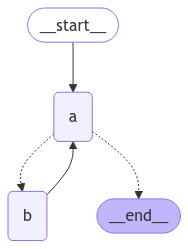

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

This architecture is similar to a [ReAct agent](../../how-tos/#prebuilt-react-agent) in which node `"a"` is a tool-calling model, and node `"b"` represents the tools.

In our `route` conditional edge, we specify that we should end after the `"aggregate"` list in the state passes a threshold length.

Invoking the graph, we see that we alternate between nodes `"a"` and `"b"` before terminating once we reach the termination condition.

In [3]:
graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

## Impose a recursion limit

In some applications, we may not have a guarantee that we will reach a given termination condition. In these cases, we can set the graph's [recursion limit](../../concepts/low_level/#recursion-limit). This will raise a `GraphRecursionError` after a given number of [supersteps](../../concepts/low_level/#graphs). We can then catch and handle this exception:

In [4]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Recursion Error


Note that this time we terminate after the fourth step.

## Loops with branches

To better understand how the recursion limit works, let's consider a more complex example. Below we implement a loop, but one step fans out into two nodes:

In [5]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Node D sees {state["aggregate"]}')
    return {"aggregate": ["D"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "c")
builder.add_edge("b", "d")
builder.add_edge(["c", "d"], "a")
graph = builder.compile()

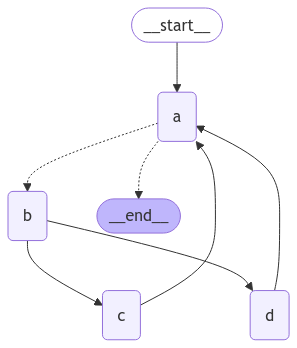

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

This graph looks complex, but can be conceptualized as loop of [supersteps](../../concepts/low_level/#graphs):

1. Node A
2. Node B
3. Nodes C and D
4. Node A
5. ...

We have a loop of four supersteps, where nodes C and D are executed concurrently.

Invoking the graph as before, we see that we complete two full "laps" before hitting the termination condition:

In [7]:
result = graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node D sees ['A', 'B']
Node C sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Node B sees ['A', 'B', 'C', 'D', 'A']
Node D sees ['A', 'B', 'C', 'D', 'A', 'B']
Node C sees ['A', 'B', 'C', 'D', 'A', 'B']
Node A sees ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


However, if we set the recursion limit to four, we only complete one lap because each lap is four supersteps:

In [8]:
from langgraph.errors import GraphRecursionError

try:
    result = graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node C sees ['A', 'B']
Node D sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Recursion Error
